In [137]:
from torch import optim
from torch import nn

# data
num_samples = int(1e4)

from models.FITS_padding import FITS
# from models.FITS import FITS
# from models.deep_FITS_after_upscaler import FITS
from argparse import Namespace

n_epochs = 300
batch_size = 1
seq_len = 720
base_freq = 96
cut_off_harmonic = 10
cutoff_freq = int((seq_len / base_freq) * cut_off_harmonic)

args = Namespace(
    dominance_freq=cutoff_freq,
    seq_len=seq_len,
    pred_len=120,
    channels=1,
    individual=False,
    debug=True,
    num_hidden=64,
    num_layers=3,
    scalar=0.55,
)

print("dominance frequency:", args.dominance_freq)
model = FITS(args)

print(model)
print(f"Parameters {sum(p.numel() for p in model.parameters())}")

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

dominance frequency: 75
FITS(
  (frequency_upsampler): Linear(in_features=75, out_features=170, bias=True)
)
Parameters 12920


In [138]:
import numpy as np
import torch
from torch import nn
np.random.seed(42)

early_stopping = False

def train(model, model_optim, n_channels, y, num_samples, epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    min_delta = 0.000001  # minimum change to qualify as an improvement
    criterion = nn.MSELoss()

    for epoch in range(epochs):  # train for specified epochs
        order = np.random.permutation(
            int(num_samples * 0.8)
        )  # shuffle the training sample
        train_loss = []
        for batch in range(25):  # split each epoch into 25 batches
            batch_start = order[
                batch * batch_size : (batch + 1) * batch_size
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + args.seq_len + args.pred_len])

            batch_xy = np.array(batch).reshape(
                batch_size, seq_len + args.pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :args.seq_len, :]
            batch_y = batch_xy[:, args.seq_len:, :]

            model_optim.zero_grad()

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            train_loss.append(loss.item())

            loss.backward()
            model_optim.step()

        mean_train_loss = np.mean(train_loss)
        val_loss = validate(model, n_channels, y, num_samples, criterion)
        
        # Print progress
        if early_stopping:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}")

            # Check early stopping condition
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs")
                break
        else:
            print(f"\repoch: {epoch} loss: {mean_train_loss:.8f} val_loss: {val_loss:.8f}", flush=True, end="")

    return model, mean_train_loss

def validate(model, n_channels, y, num_samples, criterion):
    model.eval()
    with torch.no_grad():
        order = np.random.permutation(
            int(num_samples * 0.2) + int(num_samples * 0.8)
        )[int(num_samples * 0.8):]  # select validation samples
        val_loss = []
        for batch in range(5):  # split validation into 5 batches
            batch_start = order[
                batch * batch_size : (batch + 1) * batch_size
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + args.seq_len + args.pred_len])

            batch_xy = np.array(batch).reshape(
                batch_size, args.seq_len + args.pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :args.seq_len, :]
            batch_y = batch_xy[:, args.seq_len:, :]

            output = model(batch_x)

            loss = criterion(output, batch_xy)
            val_loss.append(loss.item())

    model.train()
    return np.mean(val_loss)

# fits, train_loss = train(model, model_optim, 1, y, num_samples, n_epochs)

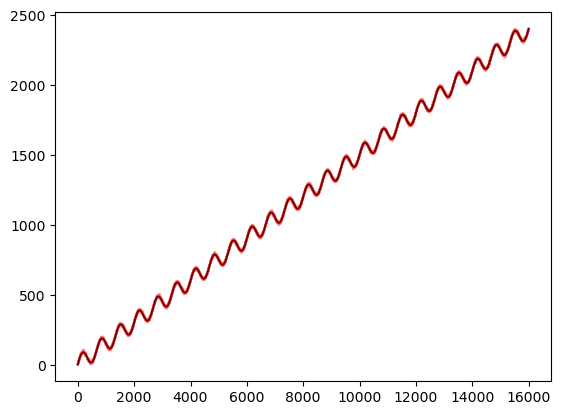

In [139]:
from synthgen import SyntheticDatasetGenerator
import matplotlib.pyplot as plt

y = SyntheticDatasetGenerator(length=16000)
y.add_sin_wave(amplitude=60, frequency=24)
y.add_noise(mean=15, std=5)
y.add_linear_trend(0.15, intercept=1)
y = y.data
og_signal = SyntheticDatasetGenerator(length=16000)
og_signal.add_sin_wave(amplitude=60, frequency=24)
og_signal.add_linear_trend(0.15, intercept=1)
og_signal = og_signal.data

plt.plot(og_signal, color='black')
plt.plot(y, color='red', alpha=0.5)

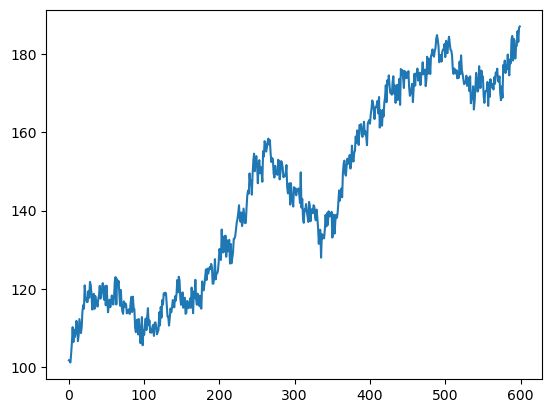

In [140]:
stock_data = SyntheticDatasetGenerator(length=600)
stock_data.add_linear_trend(0.15, intercept=100)
stock_data.add_sin_wave(amplitude=2, frequency=10)
stock_data.add_sin_wave(amplitude=5, frequency=5)
stock_data.add_sin_wave(amplitude=10, frequency=3)
stock_data.add_sin_wave(amplitude=2, frequency=30)
# stock_data_og.add_noise(mean=0, std=1)
og_signal = stock_data.data
stock_data.add_noise(mean=10, std=2)
y = stock_data.data

# plt.plot(og_signal, color='black')
# plt.plot(y, color='red', alpha=0.9)
plt.plot(y)

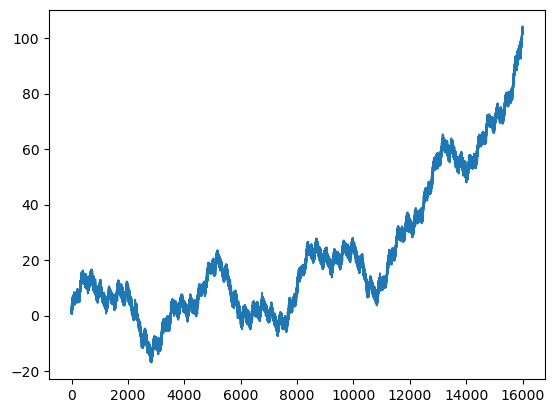

In [141]:
stock_data = SyntheticDatasetGenerator(length=16000)
stock_data.add_sin_wave(amplitude=1, frequency=100)
stock_data.add_sin_wave(amplitude=2, frequency=50)
stock_data.add_sin_wave(amplitude=5, frequency=10)
stock_data.add_sin_wave(amplitude=10, frequency=4)
stock_data.add_exponential_growth(1.00029)
# stock_data_og.add_noise(mean=0, std=1)
og_signal = stock_data.data
stock_data.add_noise(mean=10, std=1)
y = stock_data.data

# plt.plot(og_signal, color='black')
# plt.plot(y, color='red', alpha=0.9)
plt.plot(y)

In [142]:
# data
num_samples = int(1e4)

from models.FITS_padding import FITS
from argparse import Namespace

n_epochs = 300
batch_size = 1
seq_len = 720
base_freq = 96
cut_off_harmonic = 10
cutoff_freq = int((seq_len / base_freq) * cut_off_harmonic)

args = Namespace(
    dominance_freq=20,#cutoff_freq,
    seq_len=seq_len,
    pred_len=720*2,
    channels=1,
    individual=False,
    debug=True,
    num_hidden=64,
    num_layers=3,
    scalar=0.05,
)

print("dominance frequency:", args.dominance_freq)
model = FITS(args)

print(model)
print(f"Parameters {sum(p.numel() for p in model.parameters())}")

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

fits, train_loss = train(model, model_optim, 1, y, num_samples, n_epochs)

dominance frequency: 20
FITS(
  (frequency_upsampler): Linear(in_features=20, out_features=62, bias=True)
)
Parameters 1302
epoch: 299 loss: 79.88615919 val_loss: 91.7849189855

In [143]:
num_samples = len(y)
pred_len = args.pred_len
train_ratio = 0.705

from models.ARIMA import ARIMA
from models.baseline import NaiveForecast
from models.baseline import AverageForecast
from parser import parser # type: ignore    

# Prepare the data
train_size = int(num_samples * train_ratio)
train_data = y[:train_size]
test_data = y[train_size:]

# Initialize the baseline models and FITS
args_ = parser.parse_args(["--pred_len", str(pred_len), "--seq_len", str(seq_len), "--debug"])
naive = NaiveForecast(args_)
arima = ARIMA(args_)
average = AverageForecast(args_)

trained_models = [("ARIMA", arima), ("NF", naive), ("Average", average), ("FITS", fits)]

# Train and test the baseline models
start_idx = train_size - seq_len
end_idx = train_size

real_data = np.concatenate((train_data[start_idx:], test_data[:pred_len]), axis=0)

og_signal_data = og_signal[:num_samples]
og_signal_pred = og_signal_data[end_idx:end_idx+pred_len]

def RMAE(output, target):
    return torch.sqrt(torch.mean(torch.abs(output - target)))

criterion_mse = nn.MSELoss()
criterion_rmae = RMAE

# ARIMA
with torch.no_grad():
    batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    output = arima(batch_x)
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    output_arima = output[:, :pred_len, 0:]
    loss_mse_arima = criterion_mse(output_arima, batch_y)
    loss_rmae_arima = criterion_rmae(output_arima, batch_y)

# Naive Forecast
with torch.no_grad():
    batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    output = naive(batch_x)
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    output_naive = output[:, -pred_len:, :]
    loss_mse_naive = criterion_mse(output_naive, batch_y)
    loss_rmae_naive = criterion_rmae(output_naive, batch_y)

# Average Forecast
with torch.no_grad():
    batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    
    output = average(batch_x)
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    output_average = output[:, -pred_len:, 0:]
    loss_mse_average = criterion_mse(output_average, batch_y)
    loss_rmae_average = criterion_rmae(output_average, batch_y)

# FITS
with torch.no_grad():
    batch_x = torch.from_numpy(train_data[start_idx:].reshape(-1, seq_len, 1)).float()
    batch_y = torch.from_numpy(test_data[:pred_len].reshape(-1, pred_len, 1)).float()
    batch_xy = torch.cat([batch_x, batch_y], dim=1)
    output = fits(batch_x)
    fits_output = output
    if type(output) == torch.tensor:
        output = output.detach().numpy()
    output_fits = output[:, -pred_len:, 0:] + output_arima - torch.mean(output[:, -pred_len:, 0:])
    print(output_fits.shape)
    loss_mse_fits = criterion_mse(output_fits, batch_y)
    loss_rmae_fits = criterion_rmae(output_fits, batch_y)


og_signal_pred = torch.from_numpy(og_signal_pred).unsqueeze(0).unsqueeze(-1).float()
og_signal_mse = criterion_mse(og_signal_pred, batch_y)
og_signal_rmae = criterion_rmae(og_signal_pred, batch_y)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2188.484, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2582.167, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2351.480, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2185.145, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2580.265, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2185.298, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2185.363, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2186.621, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2186.998, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.575 seconds
torch.Size([1, 1440, 1])


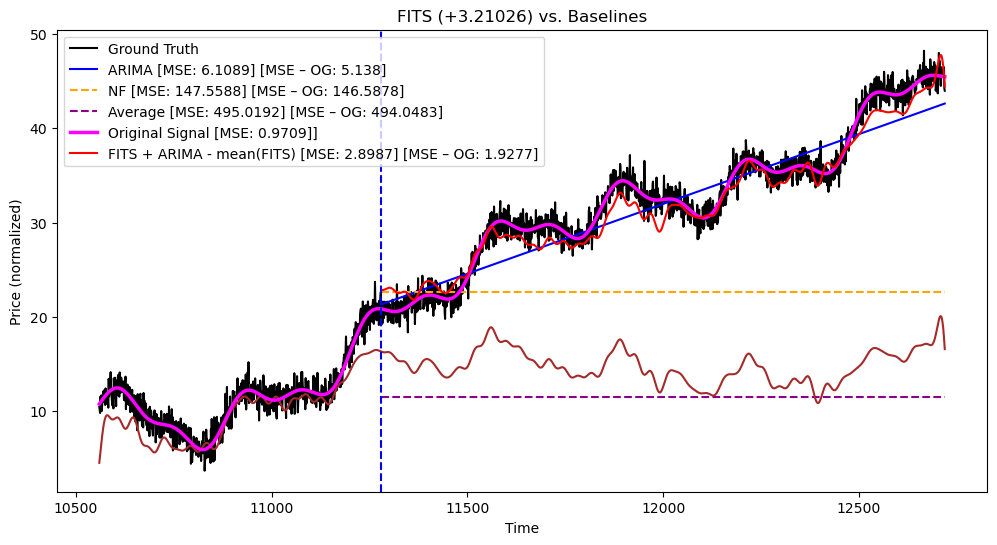

In [144]:
baselines = [
    ("ARIMA", output_arima, loss_mse_arima, loss_rmae_arima, "blue", "-"),
    ("NF", output_naive, loss_mse_naive, loss_rmae_naive, "orange", "--"),
    ("Average", output_average, loss_mse_average, loss_rmae_average, "darkmagenta", "--"),
    ("FITS_train", fits_output, loss_mse_fits, loss_rmae_fits, "brown", "-"),
    ("Original Signal", og_signal_data[start_idx:end_idx+pred_len], og_signal_mse, og_signal_rmae, "magenta", "-"),
    ("FITS + ARIMA - mean(FITS)", output_fits, loss_mse_fits, loss_rmae_fits, "red", "-"),
]

plt.figure(figsize=(12, 6))
plt.plot(list(range(start_idx, start_idx + len(real_data))), real_data, label="Ground Truth", color="black")

for name, output, mse, rmae, color, linestyle in baselines:
    if name == "FITS_train":
        plt.plot(list(range(start_idx, end_idx + pred_len)), fits_output[0, :, 0], color=color)
    elif name == "Original Signal":
        plt.plot(list(range(start_idx, end_idx + pred_len)), output, 
                 label=f"{name} [MSE: {round(mse.item(), 4)}]]", linewidth=2.5, linestyle=linestyle, color=color)
    else:
        plt.plot(list(range(end_idx, end_idx + pred_len)), output[0, :, 0], 
                 label=f"{name} [MSE: {round(mse.item(), 4)}] [MSE – OG: {round(mse.item() - og_signal_mse.item(), 4)}]", linestyle=linestyle, color=color)

best = min(loss_mse_arima, loss_mse_naive, loss_mse_average)
improvement = best - loss_mse_fits

plt.legend()

plt.axvline(x=end_idx, color="blue", linestyle="--", label="Forecast Start")

plt.title(f"FITS ({'+' if round(improvement.item(), 5) >= 0 else '-'}{abs(round(improvement.item(), 5))}) vs. Baselines")
plt.ylabel("Price (normalized)")
plt.xlabel("Time")
plt.show()